In [1]:
import torch
import torchvision
from torchvision import datasets, models, transforms
import torch.nn as nn
from torch.utils.data.sampler import SubsetRandomSampler
import torch.nn.functional as F
import torch.optim as optim #for gradient descent
import torchvision.models

import time
import os
import numpy as np

import matplotlib.pyplot as plt


In [ ]:
use_cuda = True

if use_cuda and torch.cuda.is_available():
  print('CUDA is available!  Training on GPU ...')
else:
  print('CUDA is not available.  Training on CPU ...')

CUDA is available!  Training on GPU ...


In [ ]:
# Data Loading
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
#import shutil

# Delete the directory and its contents
# shutil.rmtree('/root/datasets/images_short')
# shutil.rmtree('/root/datasets/__MACOSX/images_short')
# shutil.rmtree('/root/datasets/__MACOSX')

In [ ]:
!unzip '/content/drive/My Drive/fer2013.zip' -d '/root/datasets'

Streaming output truncated to the last 5000 lines.
  inflating: /root/datasets/fer2013/validation/surprise/PrivateTest_40404994.jpg  
  inflating: /root/datasets/__MACOSX/fer2013/validation/surprise/._PrivateTest_40404994.jpg  
  inflating: /root/datasets/fer2013/validation/surprise/PrivateTest_34706936.jpg  
  inflating: /root/datasets/__MACOSX/fer2013/validation/surprise/._PrivateTest_34706936.jpg  
  inflating: /root/datasets/fer2013/validation/surprise/PrivateTest_24065334.jpg  
  inflating: /root/datasets/__MACOSX/fer2013/validation/surprise/._PrivateTest_24065334.jpg  
  inflating: /root/datasets/fer2013/validation/surprise/PublicTest_83217196.jpg  
  inflating: /root/datasets/__MACOSX/fer2013/validation/surprise/._PublicTest_83217196.jpg  
  inflating: /root/datasets/fer2013/validation/surprise/PrivateTest_23824214.jpg  
  inflating: /root/datasets/__MACOSX/fer2013/validation/surprise/._PrivateTest_23824214.jpg  
  inflating: /root/datasets/fer2013/validation/surprise/PrivateTes

In [ ]:
# define training and test data directories
data_dir = '/root/datasets/fer2013'
train_dir = os.path.join(data_dir, 'train/')
val_dir = os.path.join(data_dir, 'validation/')
print(train_dir)
print(val_dir)

# classes are folders in each directory with these names
classes = ['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise']

/root/datasets/fer2013/train/
/root/datasets/fer2013/validation/


In [ ]:
# load and transform data using ImageFolder

# resize all images to 224 x 224
data_transform = transforms.Compose([transforms.Resize((224, 224)),
                                     transforms.CenterCrop(224),
                                      transforms.ToTensor()])

train_data = datasets.ImageFolder(train_dir, transform=data_transform)
val_data = datasets.ImageFolder(val_dir, transform=data_transform)

# print out some data stats
print('Num training images: ', len(train_data))
print('Num validation images: ', len(val_data))
print(train_data.class_to_idx)
print(val_data.class_to_idx)

Num training images:  28709
Num validation images:  7178
{'angry': 0, 'disgust': 1, 'fear': 2, 'happy': 3, 'neutral': 4, 'sad': 5, 'surprise': 6}
{'angry': 0, 'disgust': 1, 'fear': 2, 'happy': 3, 'neutral': 4, 'sad': 5, 'surprise': 6}


In [ ]:
# define dataloader parameters
batch_size  = 1024
num_workers = 0

# prepare data loaders
def get_relevant_indices(dataset, classes, target_classes):
    """ Return the indices for datapoints in the dataset that belongs to the
    desired target classes, a subset of all possible classes.

    Args:
        dataset: Dataset object
        classes: A list of strings denoting the name of each class
        target_classes: A list of strings denoting the name of desired classes
                        Should be a subset of the 'classes'
    Returns:
        indices: list of indices that have labels corresponding to one of the
                 target classes
    """
    indices = []
    for i in range(len(dataset)):
        # Check if the label is in the target classes
        label_index = dataset[i][1] # ex: 3
        label_class = classes[label_index] # ex: 'cat'
        if label_class in target_classes:
            indices.append(i)
    return indices

relevant_train_indices = get_relevant_indices(train_data, ['angry','disgust','fear','happy','neutral','sad','surprise'], ['angry','disgust','fear','happy','neutral','sad','surprise'])
relevant_val_indices = get_relevant_indices(val_data, ['angry','disgust','fear','happy','neutral','sad','surprise'], ['angry','disgust','fear','happy','neutral','sad','surprise'])

np.random.seed(1000) # Fixed numpy random seed for reproducible shuffling
np.random.shuffle(relevant_train_indices)
np.random.shuffle(relevant_val_indices)

split_train = int(len(relevant_train_indices) * 1)
split_val = int(len(relevant_val_indices) * 1)

relevant_train_indices = relevant_train_indices[:split_train]
relevant_val_indices = relevant_val_indices[:split_val]

train_sampler = SubsetRandomSampler(relevant_train_indices)
val_sampler = SubsetRandomSampler(relevant_val_indices)

train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size,
                                           num_workers=num_workers, sampler=train_sampler)
val_loader = torch.utils.data.DataLoader(val_data, batch_size=batch_size,
                                          num_workers=num_workers, sampler=val_sampler)

In [ ]:
print(len(train_loader.sampler))
print(len(val_loader.sampler))

print(len(train_loader))
print(len(val_loader))

14354
3589
15
4


tensor([2, 3, 5,  ..., 5, 5, 4])


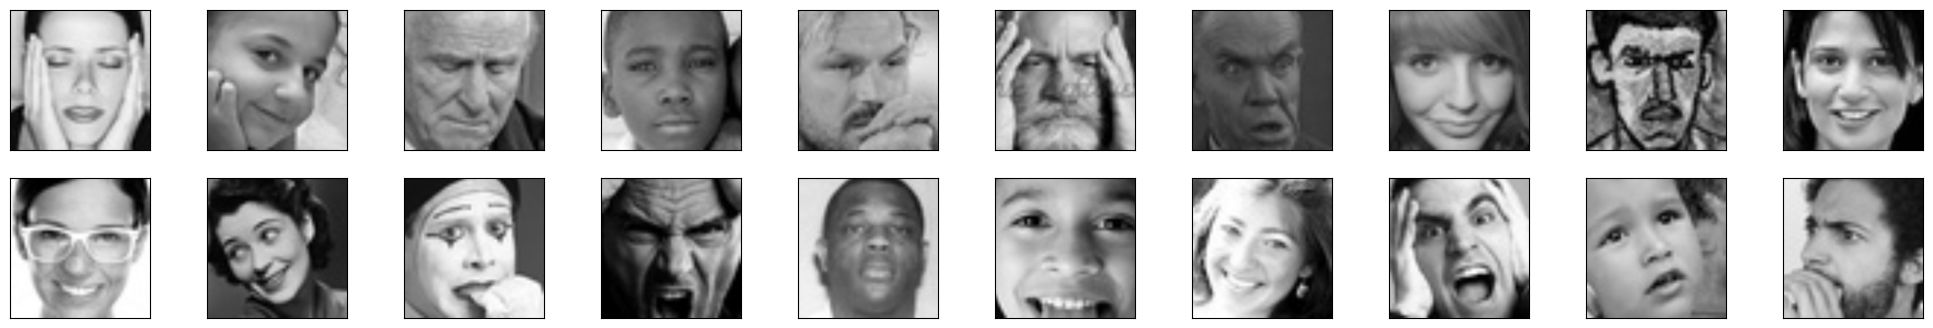

In [ ]:
# Visualize some sample data

# obtain one batch of training images
dataiter = iter(train_loader)
images, labels = next(dataiter)
print(labels)
images = images.numpy() # convert images to numpy for display

# plot the images in the batch, along with the corresponding labels
fig = plt.figure(figsize=(25, 4))
for idx in np.arange(20):
    ax = fig.add_subplot(2, int(20/2), idx+1, xticks=[], yticks=[])
    plt.imshow(np.transpose(images[idx], (1, 2, 0)))

In [ ]:
torch.cuda.empty_cache()
!nvidia-smi

Sun Jun 30 22:37:35 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA A100-SXM4-40GB          Off | 00000000:00:04.0 Off |                    0 |
| N/A   32C    P0              45W / 400W |      5MiB / 40960MiB |      0%      Default |
|                                         |                      |             Disabled |
+-----------------------------------------+----------------------+--

In [ ]:
# Implement AlexNet

torch.manual_seed(1) # set the random seed

# obtain one batch of training images
dataiter = iter(train_loader)
images, labels = next(dataiter)
print('images shape')
print(images.shape)

# confirm output from AlexNet feature extraction
alexNet = torchvision.models.alexnet(pretrained=True)
features = alexNet.features(images)
print('features shape')
features.shape

images shape
torch.Size([1024, 3, 224, 224])


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


features shape


torch.Size([1024, 256, 6, 6])

In [ ]:
#Artifical Neural Network Architecture
class ANNClassifier(nn.Module):
    def __init__(self):
        super(ANNClassifier, self).__init__()
        self.fc1 = nn.Linear(256 * 6 * 6, 10)
        self.fc2 = nn.Linear(10, 7)

    def forward(self, x):
        x = x.view(-1, 256 * 6 * 6) #flatten feature data
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

In [ ]:
def get_accuracy(model, train=False):
    if train:
        data_loader = train_loader
    else:
        data_loader = val_loader

    correct = 0
    total = 0
    for imgs, labels in data_loader:


        #############################################
        #To Enable GPU Usage
        if use_cuda and torch.cuda.is_available():
          imgs = imgs.cuda()
          labels = labels.cuda()
        #############################################

        output = model(ALNC(imgs))

        #select index with maximum prediction score
        pred = output.max(1, keepdim=True)[1]
        correct += pred.eq(labels.view_as(pred)).sum().item()
        total += imgs.shape[0]
    return correct / total

In [ ]:
def train(model, data, batch_size=20, num_epochs=1):
    #train_loader = torch.utils.data.DataLoader(data, batch_size=batch_size)
    # train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size,
                                           #num_workers=num_workers, shuffle=True)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)

    iters, losses, train_acc, val_acc = [], [], [], []

    # training
    n = 0 # the number of iterations
    start_time=time.time()
    for epoch in range(num_epochs):
        mini_b=0
        mini_batch_correct = 0
        Mini_batch_total = 0
        for imgs, labels in iter(train_loader):


            #############################################
            #To Enable GPU Usage
            if use_cuda and torch.cuda.is_available():
              imgs = imgs.cuda()
              labels = labels.cuda()
            #############################################

          #### ALNC is alexNet.features (AlexNet without classifier) ####

            out = model(ALNC(imgs))             # forward pass
            loss = criterion(out, labels) # compute the total loss
            loss.backward()               # backward pass (compute parameter updates)
            optimizer.step()              # make the updates for each parameter
            optimizer.zero_grad()         # a clean up step for PyTorch



            ##### Mini_batch Accuracy ##### We don't compute accuracy on the whole training set in every iteration!
            pred = out.max(1, keepdim=True)[1]
            mini_batch_correct = pred.eq(labels.view_as(pred)).sum().item()
            Mini_batch_total = imgs.shape[0]
            train_acc.append((mini_batch_correct / Mini_batch_total))
           ###########################

          # save the current training information
            iters.append(n)
            losses.append(float(loss)/batch_size)             # compute *average* loss
            val_acc.append(get_accuracy(model, train=False))  # compute validation accuracy
            n += 1
            mini_b += 1
            print("Iteration: ",n,'Progress: % 6.2f ' % ((epoch * len(train_loader) + mini_b) / (num_epochs * len(train_loader))*100),'%', "Time Elapsed: % 6.2f s " % (time.time()-start_time))


        print ("Epoch %d Finished. " % epoch ,"Time per Epoch: % 6.2f s "% ((time.time()-start_time) / (epoch +1)))


    end_time= time.time()
    # plotting
    plt.title("Training Curve")
    plt.plot(iters, losses, label="Train")
    plt.xlabel("Iterations")
    plt.ylabel("Loss")
    plt.show()

    plt.title("Training Curve")
    plt.plot(iters, train_acc, label="Training")
    plt.plot(iters, val_acc, label="Validation")
    plt.xlabel("Iterations")
    plt.ylabel("Validation Accuracy")
    plt.legend(loc='best')
    plt.show()

    train_acc.append(get_accuracy(model, train=True))
    print("Final Training Accuracy: {}".format(train_acc[-1]))
    print("Final Validation Accuracy: {}".format(val_acc[-1]))
    print ("Total time:  % 6.2f s  Time per Epoch: % 6.2f s " % ( (end_time-start_time), ((end_time-start_time) / num_epochs) ))


In [ ]:
!nvidia-smi

Sun Jun 30 22:52:55 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA A100-SXM4-40GB          Off | 00000000:00:04.0 Off |                    0 |
| N/A   33C    P0              51W / 400W |  11847MiB / 40960MiB |      0%      Default |
|                                         |                      |             Disabled |
+-----------------------------------------+----------------------+--

CUDA is available!  Training on GPU ...
Iteration:  1 Progress:   0.17  % Time Elapsed:  11.67 s 
Iteration:  2 Progress:   0.34  % Time Elapsed:  22.99 s 
Iteration:  3 Progress:   0.52  % Time Elapsed:  34.13 s 
Iteration:  4 Progress:   0.69  % Time Elapsed:  45.72 s 
Iteration:  5 Progress:   0.86  % Time Elapsed:  56.92 s 
Iteration:  6 Progress:   1.03  % Time Elapsed:  68.19 s 
Iteration:  7 Progress:   1.21  % Time Elapsed:  79.78 s 
Iteration:  8 Progress:   1.38  % Time Elapsed:  90.84 s 
Iteration:  9 Progress:   1.55  % Time Elapsed:  101.86 s 
Iteration:  10 Progress:   1.72  % Time Elapsed:  113.05 s 
Iteration:  11 Progress:   1.90  % Time Elapsed:  124.22 s 
Iteration:  12 Progress:   2.07  % Time Elapsed:  135.59 s 
Iteration:  13 Progress:   2.24  % Time Elapsed:  146.72 s 
Iteration:  14 Progress:   2.41  % Time Elapsed:  157.92 s 
Iteration:  15 Progress:   2.59  % Time Elapsed:  169.40 s 
Iteration:  16 Progress:   2.76  % Time Elapsed:  180.58 s 
Iteration:  17 Pr

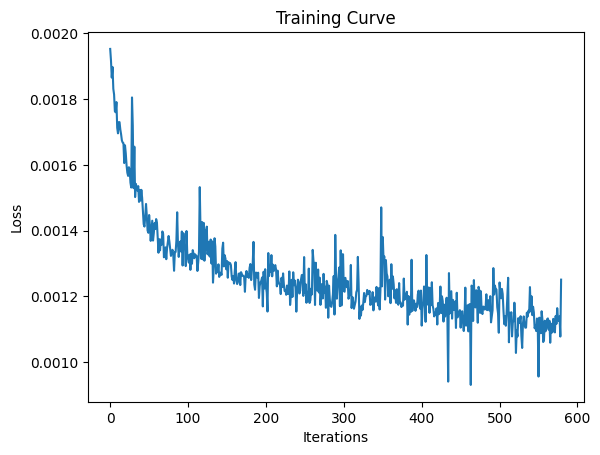

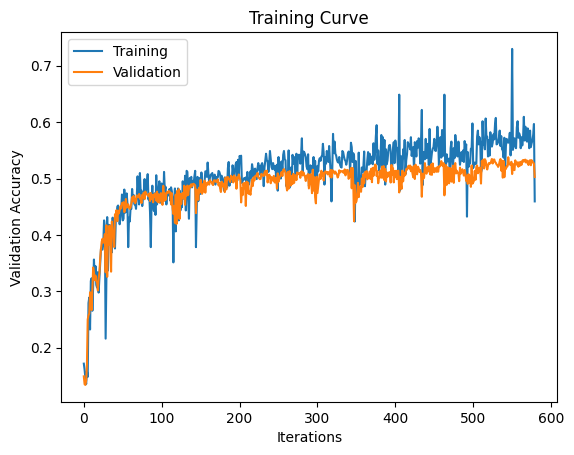

Final Training Accuracy: 0.5465533456407399
Final Validation Accuracy: 0.5027862914460852
Total time:   6494.22 s  Time per Epoch:  324.71 s 


In [ ]:
use_cuda = True

model = ANNClassifier()
ALNC = alexNet.features

if use_cuda and torch.cuda.is_available():
  ALNC.cuda()
  model.cuda()
  print('CUDA is available!  Training on GPU ...')
else:
  print('CUDA is not available.  Training on CPU ...')

#proper model
train(model, [], batch_size=1024, num_epochs=20)